# Fluid Simulation with Laplacian Eigenfunction

This notebook gives an introduction to the method introduced by de Witt et al in 2011 (see [the original paper](http://www.dgp.toronto.edu/~tyler/fluids/)).

At the end of the notebook, we also give a qualitative comparison with an Eulerian fluid simulation.

For more details on the method, see [this blog post](https://barnabasborcsok.com/posts/eigenfluid-control/) or the [CESCG 2023 paper](https://github.com/bobarna/controlling-2d-laplacian-eigenfluids)

### Uncomment this when Running in Colab

In [1]:
#!pip install --quiet phiflow==2.2.2
#import os
#if not os.path.isdir('eigenfluid-control'):
#  print("Cloning eigenfluid-control repo, this can take a moment")
#  os.system("git clone https://github.com/bobarna/eigenfluid-control")
#import sys; sys.path.append('eigenfluid-control')

# Import PhiFlow

In [2]:
#from phi.flow import *
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid
# Helper functions for visualization
from src.visu import *

import time

# Initialization Functions

In [3]:
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 20
# Number of basis fields
N = 4**2

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 10.75612187385559 seconds


In [4]:
def init_smoke():
    smoke = CenteredGrid(
        Box(x=[1,2], y=[1,2]), 
        extrapolation.BOUNDARY, 
        x=100, y=100, 
        bounds=DOMAIN
    )
    return smoke

# Visualize Some Basis Fields

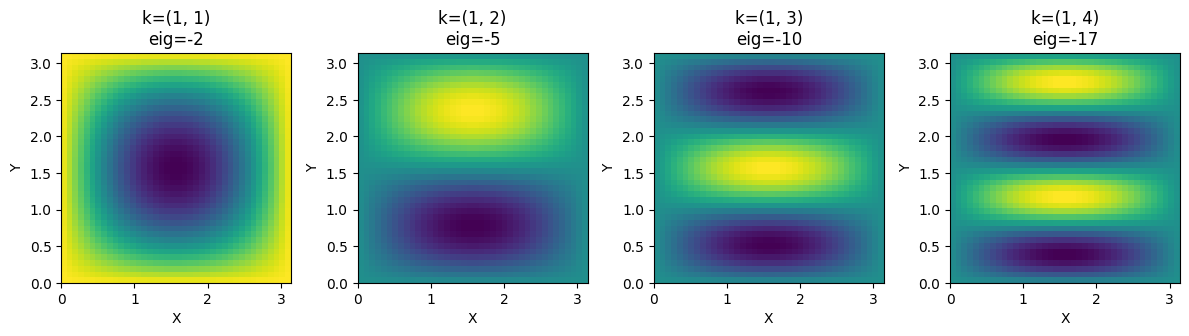

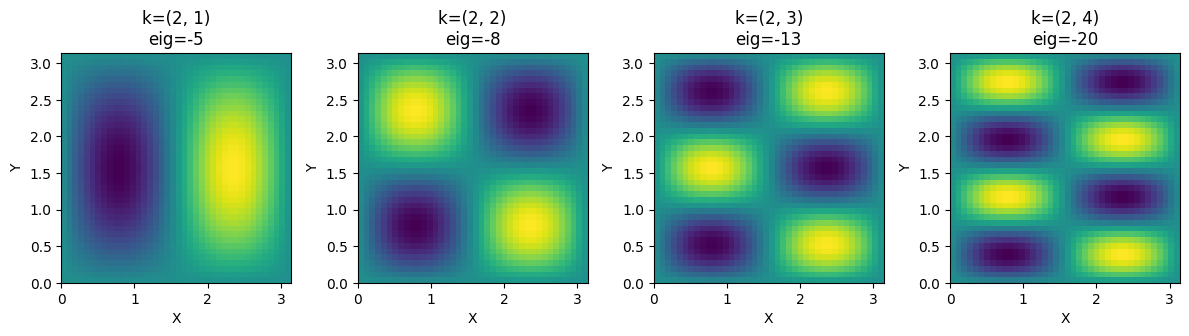

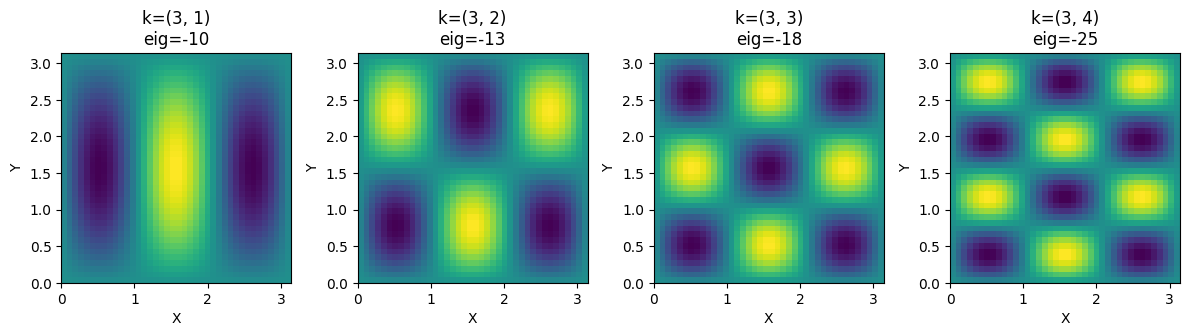

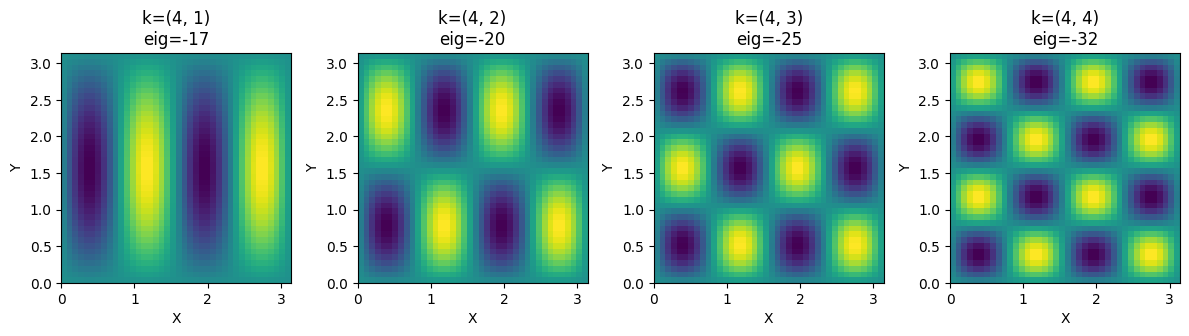

In [5]:
eigenfluid.SAMPLING_SIZE = 40

curls = []
curls_title = []

# Visualize individual velocity fields
for k in range(N):
    eigenfluid.w = tensor([1.0 if i == k else 0. for i in range(N)], eigenfluid.w.shape)
    velocity = eigenfluid.reconstruct_velocity()
    
    curls_title.append("k=({}, {})\neig={}".format(*eigenfluid.basis_fields.i[k]))
    curls.append(field.curl(velocity))

# Plot curls in NxN layout
# Note: scale is different for each plot
N_sqrt = int(math.sqrt(N))
for row in range(N_sqrt):
    plot(
        {curls_title[i]: curls[i] for i in range(N_sqrt*row, N_sqrt*row+N_sqrt)}, 
        same_scale=False,
        show_color_bar=False,
        #size=(10,10)
    )

In [6]:
# Visualize basis fields in a single simulation
eigenfluid.w = tensor([1.0 if i == 0 else 0. for i in range(N)], eigenfluid.w.shape)
eigenfluid.SAMPLING_SIZE = 60

velocity = eigenfluid.reconstruct_velocity()
smoke = CenteredGrid(Noise(smoothness=1.3), x=eigenfluid.SAMPLING_SIZE, y=eigenfluid.SAMPLING_SIZE, bounds=DOMAIN)

trajectory_w = [eigenfluid.w]
trajectory_v_eigenfluid = [velocity]
trajectory_curl_eigenfluid = [field.curl(velocity)]
trajectory_smoke_eigenfluid = [smoke]

STEPS = 1000
DT = 0.02

w_list = []
w_list = [0, 1, 5, 9, 12]

start_time = time.time()
for i in range(STEPS-1):
    if i%200 == 0:
        eigenfluid.w = tensor([1.0 if x == w_list[i//200]  else 0. for x in range(N)], eigenfluid.w.shape)
        velocity = eigenfluid.reconstruct_velocity()
    smoke = advect.mac_cormack(smoke, velocity, dt=DT)

    trajectory_w.append(eigenfluid.w)
    trajectory_v_eigenfluid.append(velocity)
    trajectory_curl_eigenfluid.append(field.curl(velocity))
    trajectory_smoke_eigenfluid.append(smoke)
    
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_w = math.stack(list(map(get_w_point_cloud, [w*100 for w in trajectory_w])), batch('time'))
trajectory_v_eigenfluid = math.stack(trajectory_v_eigenfluid, batch('time'))
trajectory_curl_eigenfluid = math.stack(trajectory_curl_eigenfluid, batch('time'))
trajectory_smoke_eigenfluid = math.stack(trajectory_smoke_eigenfluid, batch('time'))

## Plot animated basis fields
vis.plot({
    "Smoke\n(Density function)": trajectory_smoke_eigenfluid,
    "Velocity\nand Rotation": vis.overlay(
        trajectory_v_eigenfluid @ CenteredGrid(0, x=10, y=10, bounds=DOMAIN),
        trajectory_curl_eigenfluid 
    ),
    "w basis coefficients": trajectory_w
}, animate='time', same_scale=False, size=(9, 4), show_color_bar=False, frame_time=20)

Simulation finished in 73.42886972427368 seconds


<Figure size 640x480 with 0 Axes>

## Simulate Random Particles in Eigenfluid

*Note: each basis field is a stable position, so simulating the basis coefficients would simply yield the same velocity field over the time steps*

In [7]:
N_p = 1000
# Scatter N_p points in the domain
p = math.random_uniform(instance(i=N_p) & channel(vector='x,y'), low=0.0, high=math.PI)
p_velocities = eigenfluid.get_phi_at(p)

trajectory_p = [p]

STEPS = 256
DT = 0.05
VISCOSITY = 0.0

eigenfluid.SAMPLING_SIZE = 20

# Initialize basis coefficients w
eigenfluid.w = tensor([1.0 if i == 14 else 0. for i in range(N)], eigenfluid.w.shape)

for i in range(STEPS-1):
    # Get velocities at new positions
    p_velocities = eigenfluid.get_phi_at(p)
    # Midpoint
    p_velocities = eigenfluid.get_phi_at(p + p_velocities*DT/2)
    # Euler step for points
    p += p_velocities * DT
    # Save trajectory
    trajectory_p.append(p)

trajectory_p = math.stack(trajectory_p, batch('time'))
trajectory_curl = math.stack([field.curl(eigenfluid.reconstruct_velocity())]*STEPS, batch('time'))
trajectory_velocity = math.stack([eigenfluid.reconstruct_velocity()]*STEPS, batch('time'))

title_text = "k=({}, {})\neig={}".format(*eigenfluid.basis_fields.i[14]) 
vis.plot({
            #title_text: 
            "Particle simulation": 
            PointCloud(trajectory_p, bounds=DOMAIN),
            "Curl\n{}".format(title_text): trajectory_curl,
            "Velocity": trajectory_velocity/2
        },
        animate='time',
        same_scale=False,
        show_color_bar=False,
        size=(12,6),
        frame_time = 10
)

<Figure size 640x480 with 0 Axes>

<Figure size 900x600 with 2 Axes>

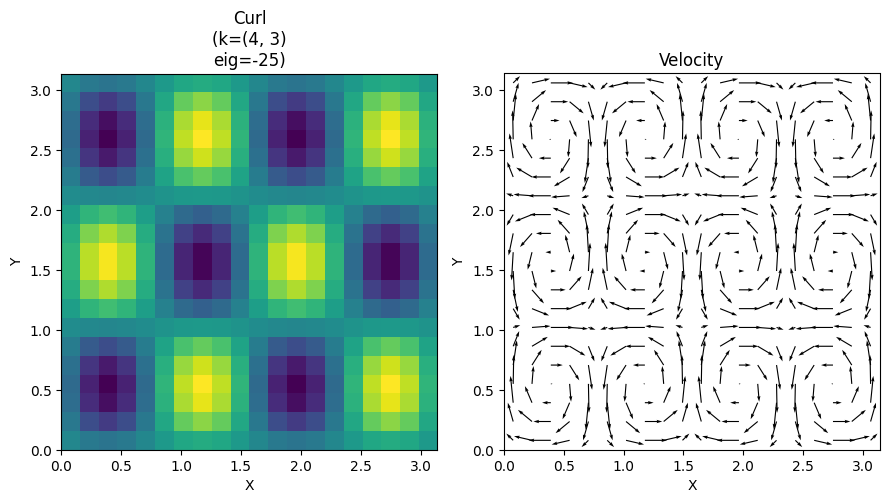

In [8]:
vis.plot({
            "Curl\n({})".format(title_text): trajectory_curl.time[0],
            "Velocity": trajectory_velocity.time[0] /2
        },
        same_scale=False,
        show_color_bar=False,
        size=(9,6),
)

# Comparison with "Traditional" (grid-based) Fluid Simulation

## Run Eigenfluid Simulation

In [9]:
eigenfluid.w = eigenfluid.get_initial_w(random=True)
#eigenfluid.w = tensor([1.0 if i == 0 else 0. for i in range(N)], eigenfluid.w.shape)
eigenfluid.SAMPLING_SIZE = 60

velocity = eigenfluid.reconstruct_velocity()
smoke = init_smoke()
#smoke = CenteredGrid(Noise(smoothness=1.3), x=eigenfluid.SAMPLING_SIZE, y=eigenfluid.SAMPLING_SIZE, bounds=DOMAIN)

trajectory_w = [eigenfluid.w]
trajectory_v_eigenfluid = [velocity]
trajectory_curl_eigenfluid = [field.curl(velocity)]
trajectory_smoke_eigenfluid = [smoke]

STEPS = 100
DT = 0.05

#STEPS = 2000
#DT = 0.02

w_list = []
w_list = [0, 1, 5, 9, 12]

start_time = time.time()
for i in range(STEPS-1):
    #if i%200 == 0:
    #    eigenfluid.w = tensor([1.0 if x == w_list[i//200]  else 0. for x in range(N)], eigenfluid.w.shape)
    #    velocity = eigenfluid.reconstruct_velocity()
    smoke = advect.mac_cormack(smoke, velocity, dt=DT)

    trajectory_w.append(eigenfluid.w)
    trajectory_v_eigenfluid.append(velocity)
    trajectory_curl_eigenfluid.append(field.curl(velocity))
    trajectory_smoke_eigenfluid.append(smoke)
    
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_w = math.stack(list(map(get_w_point_cloud, [w*100 for w in trajectory_w])), batch('time'))
trajectory_v_eigenfluid = math.stack(trajectory_v_eigenfluid, batch('time'))
trajectory_curl_eigenfluid = math.stack(trajectory_curl_eigenfluid, batch('time'))
trajectory_smoke_eigenfluid = math.stack(trajectory_smoke_eigenfluid, batch('time'))

Simulation finished in 10.190274953842163 seconds


## Run Grid-Based Fluid Simulation

In [10]:
eigenfluid.w = eigenfluid.get_initial_w(random=True)
velocity = eigenfluid.reconstruct_velocity()
smoke = init_smoke()

eigenfluid.SAMPLING_SIZE = 60

trajectory_v_trad = [velocity]
trajectory_curl_trad = [field.curl(velocity)]
trajectory_smoke_trad = [smoke]

STEPS = 100
DT = 0.05

start_time = time.time()
for i in range(STEPS-1):
    velocity = advect.semi_lagrangian(velocity, velocity, dt=DT)
    velocity, _ = fluid.make_incompressible(velocity)
    smoke = advect.mac_cormack(smoke, velocity, dt=DT)

    trajectory_v_trad.append(velocity)
    trajectory_curl_trad.append(field.curl(velocity))
    trajectory_smoke_trad.append(smoke)
    
    
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_v_trad = math.stack(trajectory_v_trad, batch('time'))
trajectory_curl_trad = math.stack(trajectory_curl_trad, batch('time'))
trajectory_smoke_trad = math.stack(trajectory_smoke_trad, batch('time'))

/Users/bobarna/codes/phiflow/phi/torch/_torch_backend.py:662: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)


Simulation finished in 44.72666597366333 seconds


## Plot Comparison

In [11]:
## GRID-BASED SIMULATION
vis.plot({
    "Smoke\n(Density function)": trajectory_smoke_trad,
    "Velocity\nand Rotation": vis.overlay(
        trajectory_v_trad @ CenteredGrid(0, x=10, y=10, bounds=DOMAIN) * 2,
        trajectory_curl_trad
    )
}, animate='time', same_scale=False, size=(6,4), frame_time = 20, show_color_bar=True)

<Figure size 640x480 with 0 Axes>

In [12]:
## EIGENFLUID SIMULATION
vis.plot({
    "Smoke\n(Density function)": trajectory_smoke_eigenfluid,
    "Velocity\nand Rotation": vis.overlay(
        trajectory_v_eigenfluid @ CenteredGrid(0, x=10, y=10, bounds=DOMAIN),
        trajectory_curl_eigenfluid 
    ),
    "w basis coefficients": trajectory_w
}, animate='time', same_scale=False, size=(9, 4), show_color_bar=False, frame_time=20)

<Figure size 640x480 with 0 Axes>

## Show difference after 100 steps (dt=0.05)

The velocity was reconstructed on a $60\times60$ grid. Note that the eigenfluid simulation is independent of the grid resolution, and the velocity reconstructing is only an optional extra step (in this case, necessitated by the smoke simulation step).

<Figure size 1200x500 with 3 Axes>

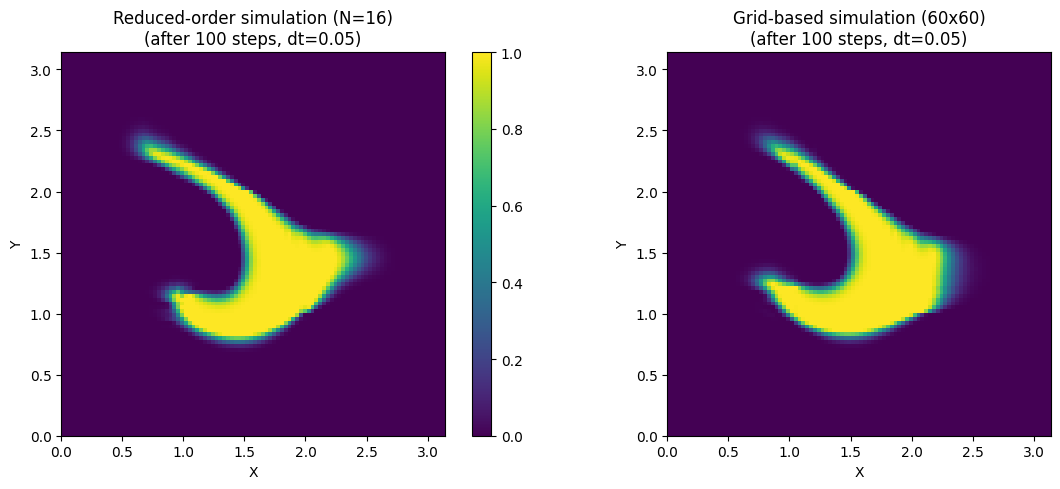

In [13]:
vis.plot({
    "Reduced-order simulation (N=16)\n(after 100 steps, dt=0.05)": trajectory_smoke_eigenfluid.time[-1],
    "Grid-based simulation (60x60)\n(after 100 steps, dt=0.05)": trajectory_smoke_trad.time[-1]
})